In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import datetime
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config


In [2]:
if config.ADSMI:
    from DL_pretrain import ADSMI_DL_NP_petrain as DL
    Data_name = 'ADSMI'

# clear cuda cache
torch.cuda.empty_cache()

In [3]:

class ContrastiveTripletLoss(nn.Module):
    def __init__(self, margin=0.5, temperature=0.07):
        super(ContrastiveTripletLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        Args:
        - anchor: Embeddings from log_s_po_aug1
        - positive: Embeddings from log_s_po_aug2
        - negative: Embeddings from log_s_neg_aug1

        Returns:
        - A loss scalar.
        """
        # L2 normalize the embeddings
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute similarities
        pos_sim = F.cosine_similarity(anchor, positive) / self.temperature
        neg_sim = F.cosine_similarity(anchor, negative) / self.temperature

        # Compute the triplet loss
        losses = F.relu(self.margin - pos_sim + neg_sim)

        return losses.mean()

# Model with PH

In [4]:
print(config.channels)

class ContrastiveTripletModelwithPH(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModelwithPH, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer (with 50% probability, adjust as needed)
        #self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
    
class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
import timm
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveTripletModelwithPHEfficient(nn.Module):
    def __init__(self, embedding_dim=1280, projection_dim=128, efficientnet_version='efficientnet_b0'):
        super(ContrastiveTripletModelwithPHEfficient, self).__init__()
        # Load a pre-trained EfficientNet. The last FC layer will be removed automatically.
        self.efficientnet = timm.create_model(efficientnet_version, pretrained=False, features_only=True)

        # Calculate the feature dimension of EfficientNet
        feature_dim = self.efficientnet.feature_info.channels()[-1]
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(feature_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        # Dropout layer (if needed)
        #self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.efficientnet(x)[-1]  # Get the last set of features
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global Average Pooling and Flatten
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


In [5]:

patience = 30  # or whatever value you deem appropriate
early_stop_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(config.epochs)
print(config.batch_size)


# Initialization
#model = ContrastiveTripletModel().to(device)
model = ContrastiveTripletModelwithPH().to(device)
#model = ContrastiveTripletModelwithPHEfficient().to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = ContrastiveTripletLoss()

# Data
train_loader, test_loader = DL.create_generators()



300
32


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Number of files:  39177
2013-10-18_15-48-26_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_15-48-26_01.WAV
Number of files:  5596
2013-10-18_17-03-06_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_17-03-06_01.WAV


In [6]:
#select first sample from train loader
#sample = next(iter(train_loader))
#print(sample)

from Pipelines.Pipeline_FT_SA import MyPipelinePreTrain
import torchaudio
path = 'G:/Dokumente/MAData/Unlabeled_all/2013-10-18_22-33-15_01.WAV'
pipeline = MyPipelinePreTrain(input_sample_rate=config.goal_sr_labeled, device=torch.device("cuda"), desired_length_in_seconds=6, train=True)
pipeline.to(device=torch.device("cuda"), dtype=torch.float32) 
w,s = torchaudio.load(path)
w = w.to(device=torch.device("cuda"), dtype=torch.float32)
print(w)
pipeline(s,w,goal_r=config.goal_sr_unlabeled)

tensor([[-0.9792, -0.6914, -0.4544,  ..., -0.0760, -0.0940, -0.0701]],
       device='cuda:0')


tensor([[[14.9110, 25.2006, 33.6648,  ..., 18.0502, 31.8520, 33.5493],
         [23.2541, 27.4348, 31.1474,  ..., 20.9930, 28.9970, 26.6051],
         [28.2000, 26.3811, 28.4030,  ..., 21.4702, 27.3056, 30.5731],
         ...,
         [24.9953, 26.0914, 27.2165,  ..., 15.9838, 16.7543, 17.6641],
         [22.6453, 21.8036, 21.0903,  ...,  2.0386, -3.5755, -5.2072],
         [23.0776, 21.3486, 20.7954,  ..., -7.4489, -7.5933, -6.9909]],

        [[14.9110, 25.2006, 33.6648,  ..., 18.0502, 31.8520, 33.5493],
         [23.2541, 27.4348, 31.1474,  ..., 20.9930, 28.9970, 26.6051],
         [28.2000, 26.3811, 28.4030,  ..., 21.4702, 27.3056, 30.5731],
         ...,
         [24.9953, 26.0914, 27.2165,  ..., 15.9838, 16.7543, 17.6641],
         [22.6453, 21.8036, 21.0903,  ...,  2.0386, -3.5755, -5.2072],
         [23.0776, 21.3486, 20.7954,  ..., -7.4489, -7.5933, -6.9909]],

        [[14.9110, 25.2006, 33.6648,  ..., 18.0502, 31.8520, 33.5493],
         [23.2541, 27.4348, 31.1474,  ..., 20

In [7]:
#gt first sample from test loader
sample = next(iter(train_loader))


In [8]:
from torch.profiler import profile, record_function, ProfilerActivity

epochs = config.epochs
training_losses = []
validation_losses = []


#load model
#model = torch.load('results/CLR-2023-11-08-19-epochs-300-ADSMI/checkpoint.pth')
# Create log directory
current_date = datetime.datetime.now().strftime('%Y-%m-%d-%H')
log_dir = f"./results/CLR-{current_date}-epochs-{epochs}-{Data_name}"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Log file path
log_file_path = os.path.join(log_dir, "training_log.txt")

best_loss = float('inf')

# Training and Validation loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_loader), total=len(train_loader)):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)   
        optimizer.zero_grad()

        anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
        
        #print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
        loss = criterion(anchor_repr, positive_repr, negative_repr)
        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_loader), total=len(test_loader)):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
            loss = criterion(anchor_repr, positive_repr, negative_repr)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Log to file
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        print("Validation Loss improved! Checkpointing the model...")
        torch.save(model, os.path.join(log_dir, f"checkpoint.pth"))  # Modified this line
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Validation Loss improved at Epoch {epoch+1}.\n")
        early_stop_counter = 0  # reset counter
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print("Early stopping!")
        break

# Plot training and validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


100%|██████████| 175/175 [00:56<00:00,  3.11it/s]


Epoch [1/300] Training Loss: 0.1102, Validation Loss: 0.0223
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:56<00:00,  3.09it/s]


Epoch [2/300] Training Loss: 0.0423, Validation Loss: 0.0179
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:56<00:00,  3.07it/s]


Epoch [3/300] Training Loss: 0.0279, Validation Loss: 0.0153
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [01:02<00:00,  2.78it/s]


Epoch [4/300] Training Loss: 0.0237, Validation Loss: 0.0118
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:57<00:00,  3.04it/s]


Epoch [5/300] Training Loss: 0.0201, Validation Loss: 0.0094
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:57<00:00,  3.07it/s]


Epoch [6/300] Training Loss: 0.0186, Validation Loss: 0.0082
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [7/300] Training Loss: 0.0154, Validation Loss: 0.0058
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [8/300] Training Loss: 0.0128, Validation Loss: 0.0086


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [9/300] Training Loss: 0.0121, Validation Loss: 0.0050
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [10/300] Training Loss: 0.0112, Validation Loss: 0.0050
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [11/300] Training Loss: 0.0109, Validation Loss: 0.0044
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [12/300] Training Loss: 0.0093, Validation Loss: 0.0048


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [13/300] Training Loss: 0.0096, Validation Loss: 0.0069


100%|██████████| 175/175 [00:56<00:00,  3.09it/s]


Epoch [14/300] Training Loss: 0.0085, Validation Loss: 0.0052


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [15/300] Training Loss: 0.0071, Validation Loss: 0.0030
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [16/300] Training Loss: 0.0087, Validation Loss: 0.0040


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [17/300] Training Loss: 0.0076, Validation Loss: 0.0067


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [18/300] Training Loss: 0.0064, Validation Loss: 0.0050


100%|██████████| 175/175 [00:57<00:00,  3.06it/s]


Epoch [19/300] Training Loss: 0.0065, Validation Loss: 0.0049


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [20/300] Training Loss: 0.0065, Validation Loss: 0.0027
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [21/300] Training Loss: 0.0060, Validation Loss: 0.0029


100%|██████████| 175/175 [00:56<00:00,  3.12it/s]


Epoch [22/300] Training Loss: 0.0054, Validation Loss: 0.0053


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [23/300] Training Loss: 0.0056, Validation Loss: 0.0037


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [24/300] Training Loss: 0.0057, Validation Loss: 0.0033


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [25/300] Training Loss: 0.0045, Validation Loss: 0.0023
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [26/300] Training Loss: 0.0049, Validation Loss: 0.0027


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [27/300] Training Loss: 0.0049, Validation Loss: 0.0032


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [28/300] Training Loss: 0.0056, Validation Loss: 0.0032


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [29/300] Training Loss: 0.0043, Validation Loss: 0.0046


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [30/300] Training Loss: 0.0047, Validation Loss: 0.0022
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [31/300] Training Loss: 0.0037, Validation Loss: 0.0033


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [32/300] Training Loss: 0.0039, Validation Loss: 0.0038


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [33/300] Training Loss: 0.0033, Validation Loss: 0.0029


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [34/300] Training Loss: 0.0041, Validation Loss: 0.0020
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [35/300] Training Loss: 0.0043, Validation Loss: 0.0022


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [36/300] Training Loss: 0.0029, Validation Loss: 0.0017
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [37/300] Training Loss: 0.0033, Validation Loss: 0.0027


100%|██████████| 175/175 [00:56<00:00,  3.12it/s]


Epoch [38/300] Training Loss: 0.0033, Validation Loss: 0.0036


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [39/300] Training Loss: 0.0030, Validation Loss: 0.0021


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [40/300] Training Loss: 0.0034, Validation Loss: 0.0023


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [41/300] Training Loss: 0.0033, Validation Loss: 0.0022


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [42/300] Training Loss: 0.0036, Validation Loss: 0.0018


100%|██████████| 175/175 [00:55<00:00,  3.17it/s]


Epoch [43/300] Training Loss: 0.0027, Validation Loss: 0.0034


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [44/300] Training Loss: 0.0028, Validation Loss: 0.0018


100%|██████████| 175/175 [00:55<00:00,  3.17it/s]


Epoch [45/300] Training Loss: 0.0030, Validation Loss: 0.0027


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [46/300] Training Loss: 0.0026, Validation Loss: 0.0025


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [47/300] Training Loss: 0.0024, Validation Loss: 0.0014
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:56<00:00,  3.11it/s]


Epoch [48/300] Training Loss: 0.0028, Validation Loss: 0.0018


100%|██████████| 175/175 [00:56<00:00,  3.12it/s]


Epoch [49/300] Training Loss: 0.0024, Validation Loss: 0.0017


100%|██████████| 175/175 [00:56<00:00,  3.11it/s]


Epoch [50/300] Training Loss: 0.0029, Validation Loss: 0.0026


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [51/300] Training Loss: 0.0023, Validation Loss: 0.0018


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [52/300] Training Loss: 0.0026, Validation Loss: 0.0015


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [53/300] Training Loss: 0.0023, Validation Loss: 0.0025


100%|██████████| 175/175 [00:56<00:00,  3.11it/s]


Epoch [54/300] Training Loss: 0.0025, Validation Loss: 0.0018


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [55/300] Training Loss: 0.0022, Validation Loss: 0.0017


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [56/300] Training Loss: 0.0022, Validation Loss: 0.0017


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [57/300] Training Loss: 0.0028, Validation Loss: 0.0016


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [58/300] Training Loss: 0.0021, Validation Loss: 0.0018


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [59/300] Training Loss: 0.0022, Validation Loss: 0.0018


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [60/300] Training Loss: 0.0021, Validation Loss: 0.0018


100%|██████████| 175/175 [00:55<00:00,  3.16it/s]


Epoch [61/300] Training Loss: 0.0023, Validation Loss: 0.0014
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [62/300] Training Loss: 0.0024, Validation Loss: 0.0016


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [63/300] Training Loss: 0.0020, Validation Loss: 0.0019


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [64/300] Training Loss: 0.0021, Validation Loss: 0.0023


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [65/300] Training Loss: 0.0018, Validation Loss: 0.0017


100%|██████████| 175/175 [00:56<00:00,  3.12it/s]


Epoch [66/300] Training Loss: 0.0021, Validation Loss: 0.0020


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [67/300] Training Loss: 0.0018, Validation Loss: 0.0015


100%|██████████| 175/175 [00:55<00:00,  3.14it/s]


Epoch [68/300] Training Loss: 0.0018, Validation Loss: 0.0012
Validation Loss improved! Checkpointing the model...


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [69/300] Training Loss: 0.0029, Validation Loss: 0.0019


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [70/300] Training Loss: 0.0017, Validation Loss: 0.0014


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch [71/300] Training Loss: 0.0016, Validation Loss: 0.0018


100%|██████████| 175/175 [00:56<00:00,  3.12it/s]


Epoch [72/300] Training Loss: 0.0025, Validation Loss: 0.0026


100%|██████████| 175/175 [00:55<00:00,  3.15it/s]


Epoch [73/300] Training Loss: 0.0023, Validation Loss: 0.0018


 33%|███▎      | 409/1225 [03:40<09:13,  1.47it/s]

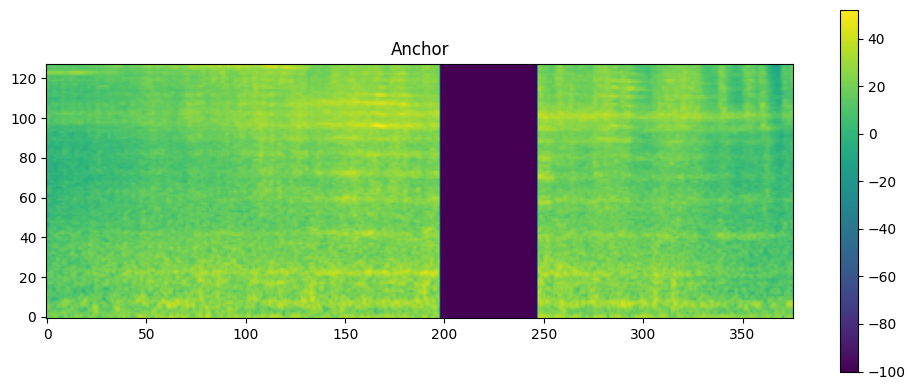

In [ ]:
#plot anchor as melspectrogram
plt.figure(figsize=(10, 4))
plt.imshow(positive[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Anchor')
plt.tight_layout()
plt.show()


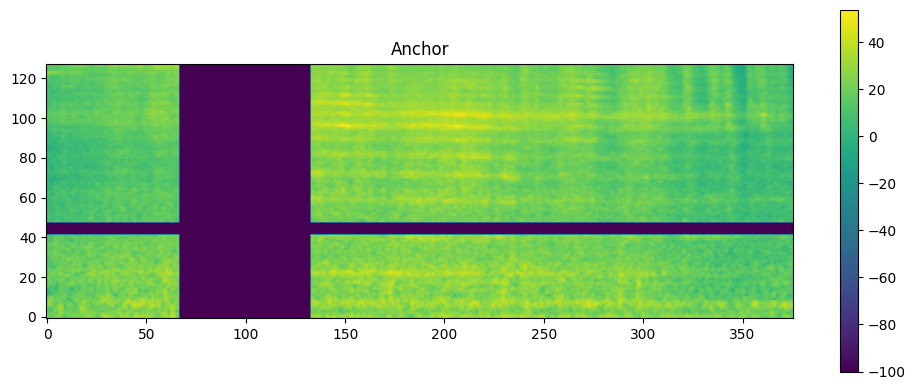

In [ ]:
#plot anchor as melspectrogram
plt.figure(figsize=(10, 4))
plt.imshow(anchor[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Anchor')
plt.tight_layout()
plt.show()

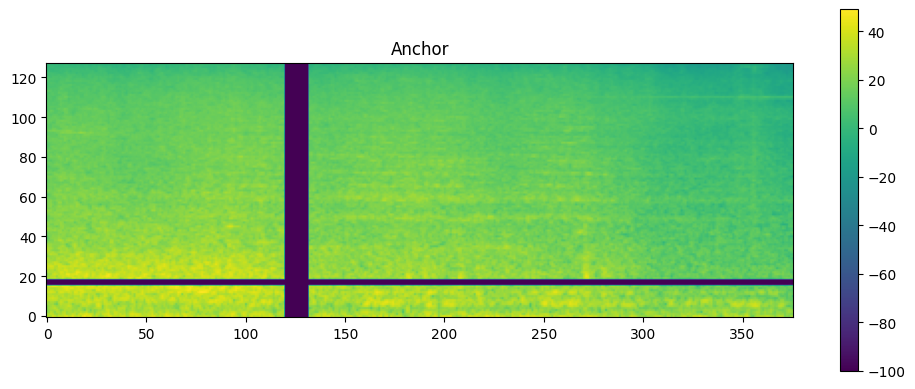

In [ ]:
#plot anchor as melspectrogram
plt.figure(figsize=(10, 4))
plt.imshow(negative[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Anchor')
plt.tight_layout()
plt.show()